In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from feature_extraction import person_finder, org_finder, state_agg, imputed_600, method_flagger

In [4]:
polls = pd.read_csv('../data/raw-polls.csv')
pollster_ratings = pd.read_csv('../data/pollster-ratings.csv')

## Data Cleaning

Before merging our data let's take a look at if we have any missing values.

In [6]:
polls.loc[:, polls.isna().sum() > 0].columns 

Index(['partisan', 'cand3_pct', 'bias', 'comment'], dtype='object')

Partisan, cand3_pct, and comment having NAs is reasonable but bias should not have any. It is possible that 538 has a reason for excluding these bias calculations but there is none listed and the data dictionary notes the exact calculation for bias so we will fix this now to make our plots are more accurate.

In [7]:
polls['calc_bias'] = polls['margin_poll'] - polls['margin_actual'] # same formula as data dictionary
np.mean(polls['error'] - np.abs(polls['calc_bias'])) # about as accurate as we can get

-9.27550055675687e-07

In [11]:
pollster_ratings.loc[:, pollster_ratings.isna().sum() > 0].columns

Index(['Mean-Reverted Bias', 'Bias', 'House Effect',
       'Average Distance from Polling Average (ADPA)'],
      dtype='object')

In [12]:
pollster_ratings[pollster_ratings.loc[:, pollster_ratings.isna().sum() > 0].columns].isna().sum()

Mean-Reverted Bias                               44
Bias                                             44
House Effect                                     62
Average Distance from Polling Average (ADPA)    108
dtype: int64

Our data here is incomplete, for the bias variables those are due to not enough polls to analyze bias on 538's part. House Effect requires a comparison to other partisan polls in the same race so these are likely NA's for a valid reason. ADPA however is a bit troubling so let's analyze that more closely.

In [13]:
pollster_ratings[pollster_ratings['Average Distance from Polling Average (ADPA)'].isna()]['Polls Analyzed'].describe()

count    108.000000
mean       2.277778
std        2.629215
min        1.000000
25%        1.000000
50%        1.500000
75%        2.000000
max       18.000000
Name: Polls Analyzed, dtype: float64

538 states their process for calculating ADPA is: we start by calculating how much the pollster’s average poll differs from the average of previous polls of that race — specifically, polls whose median field date was at least three days earlier and it is weighted based on the square root of the number of other polls in the field for each race.([source](https://fivethirtyeight.com/methodology/how-our-pollster-ratings-work/)) These NA values should be caused by races where there weren't enough other polls in the field, likely 0 previous polls. We will proceed as is because we do not intend to use any of these variables.

In [14]:
# Merging our dataframes for ease of use
df = pd.merge(left = polls, right = pollster_ratings, 
              how = 'left', 
              left_on = 'pollster_rating_id', right_on = 'Pollster Rating ID'
              )

In [86]:
df.loc[:, df.isna().sum() > 0].columns # Our merge caused new missing values so let's ensure there's no issue

Index(['cand3_pct', 'bias', 'comment', 'Rank', 'Pollster',
       'Pollster Rating ID', 'Polls Analyzed', 'AAPOR/Roper', 'Banned by 538',
       'Predictive Plus-Minus', '538 Grade', 'Mean-Reverted Bias',
       'Races Called Correctly', 'Misses Outside MOE', 'Simple Average Error',
       'Simple Expected Error', 'Simple Plus-Minus', 'Advanced Plus-Minus',
       'Mean-Reverted Advanced Plus-Minus', '# of Polls for Bias Analysis',
       'Bias', 'House Effect', 'Average Distance from Polling Average (ADPA)',
       'Herding Penalty'],
      dtype='object')

In [98]:
# First we gather the missing IDs
missing = [] 
for id in polls['pollster_rating_id'].unique():
    if int(id) not in list(df['Pollster Rating ID']):
        missing.append(id)

# Then we gather the names of the pollsters
missing_grades = []
for id in missing:
    for row in polls[polls['pollster_rating_id'] == id].values:
        if row[8] not in missing_grades:
            missing_grades.append(row[8])

# Then we count how many polls total are effected
for pollster in missing_grades:
    print(pollster, polls[polls['pollster'] == pollster].shape[0])

University of Maryland 1
Brigham Young University 4
Research America Inc. 3
Insights West 9
Sacred Heart University 2
Hofstra University 2


So, a number of our polls were done by pollsters that are not in our pollster ratings. This is unexpected and unfortunate but we don't have any way to work around this issue. Once we reach the modelling stage we will be removing these polls because we don't have information on them and we have no reasonable way to impute their values. It is somewhat troubling that 538 doesn't have these rated but we don't have any means to fix that.

## Feature Extraction

First, let's extract some features from the comment and methodology columns. Additionally, we will be cleaning the state column slightly to account for Maine and Nevada separate designations due to their unique presidential voting situation ([source](https://www.smithsonianmag.com/smart-news/why-do-maine-and-nebraska-split-their-electoral-votes-180976219/)). 

In [16]:
# These functions are defined in feature_extraction.py but basic descriptions are provided below

# Marks whether an organization is mentioned in the comment
# ie. 'for New York Daily News'
df['org'] = df['comment'].apply(
    lambda x: org_finder(x) if x is not np.nan else 0
    )

# Marks whether a person was mentioned in the comment
# ie. 'for Charles E. Schumer'
df['person'] = df['comment'].apply(
    lambda x: person_finder(x) if x is not np.nan else 0
    )

# Marks whether unspecified is in the comment
# ie. for unspecified Democratic sponsor
df['anon'] = df['comment'].str.contains('unspecified').apply(
    lambda x: 1 if x == True else 0
    )

# Marks whether poll is of 'voters' or 'registered voters'
# ie. among 'voters' || among registered voters
df['registered_voters'] = df['comment'].str.contains(
    r"registered voters|'voters'"
    ).apply(
        lambda x: 1 if x == True else 0
        ) # we are counting 'voters' as registered voters and not likely voters

# Marks whether the comment notes the poll is an average of multiple polls/models
# ie. average of multiple versions or turnout models listed in poll
df['averaged'] = df['comment'].str.contains('average').apply(
    lambda x: 1 if x == True else 0
    )

# Maps polls without partisan designations as No Party Listed (NPL)
# We also have a single 'IND' poll which is short for independent.
# This could refer to either an independent candidate or the Independent
# Party (a fringe far-right party). See below for references on this race
# but it seems like IND refers to an independent candidate in this case.
df['partisan'] = df['partisan'].map(
    {
        'D' : 'D',
        'R' : 'R',
        np.nan : 'NPL',
        'IND' : 'NPL' 
    }
)

# Gathers state designation from the location column which normally includes 
# district where applicable. The denotation 'agg' refers to us aggregating the
# Maine and Nevada districts that vote separately into the state as a whole for
# ease of analysis. 
# (https://www.smithsonianmag.com/smart-news/why-do-maine-and-nebraska-split-their-electoral-votes-180976219/)
df['state_agg'] = df['location'].apply(state_agg)

# Denotes polls with unspecified sample sizes that were imputed to be 600
# per 538's standard practice. A number of these polls had sample sizes
# that were not 600 and it is unclear why that is, this column only flags
# polls where the comment says the sample size was imputed and the listed 
# sample size is 600. Our suspicion is that polls with this comment and 
# non-600 sample sizes were polls that were originally imputed and later
# the correct value was added in but the comment was never changed.
df['imputed_600'] = imputed_600(df)

# Calculates the difference between median field date of the poll and 
# the election date. The values range from 1 day to 21 days as 538 only
# includes the 3 weeks before the election in this dataset.
df['days_bt_polldate_election'] = (pd.to_datetime(df['electiondate']) - pd.to_datetime(df['polldate'])).dt.days

# Creates flag variables from the methodology column.
# A poll can have multiple methodologies.
# ie. IVR/Online --> IVR:1, Online:1, Live Phone:0 (not exhaustive just demonstrative of the concept)
df = pd.merge(df, 
              pd.DataFrame(method_flagger(df['methodology'])), 
              left_index=True, 
              right_index=True)

In [99]:
polls[polls['partisan'] == 'IND'] # https://en.wikipedia.org/wiki/2010_Maine_gubernatorial_election
                                  # https://en.wikipedia.org/wiki/Eliot_Cutler

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,...,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,calc_bias
5093,53001,83867,1292,2010,2010_Gov-G_ME,ME,Gov-G,Gov-G,Frederick Polls,108,...,11/2/2010,43.0,31.8,11.2,5.2,NaN,1.0,1.103192,for Eliot R. Cutler,-5.2


## EDA

First we'll take a look at the correlations for a few notable variables.

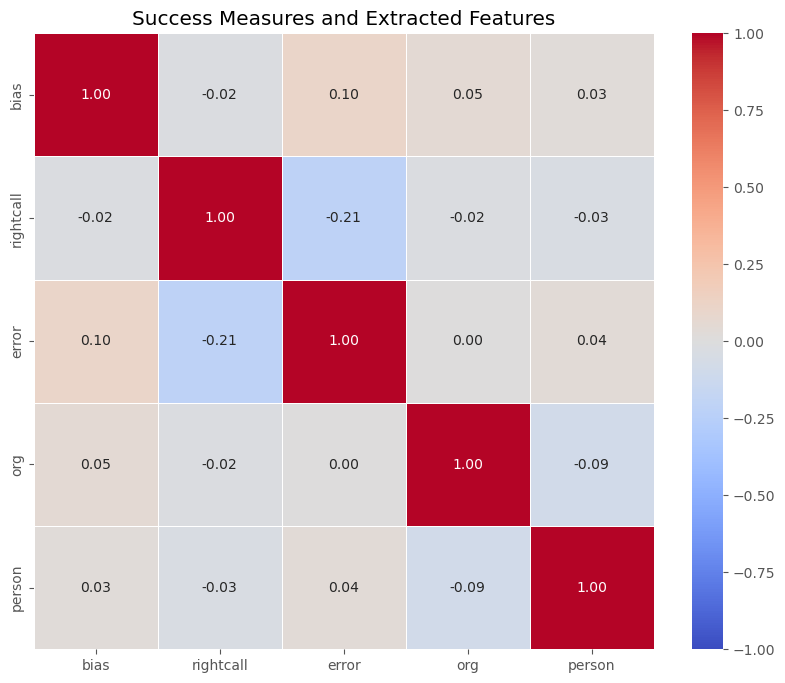

In [17]:
# Heat map exploring if being a ORG v Person is correlated with features like "rightcall" or "bias" - no strong correlations here 
heatmap_data = df[['bias', 'rightcall', 'error', 'org', 'person']]
correlation_matrix = heatmap_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, 
            cmap='coolwarm', fmt='.2f', 
            linewidths=.5, vmax = 1, vmin = -1)
plt.title('Success Measures and Extracted Features');

Clearly, we're going to run into some issues with our final modelling. Organization and person having no correlation with any of our response variables options is a good sign for polls being accurate but unideal for our hope of modelling polling accuracy. Most interestingly, all three of our response options are near-completely uncorrelated. Error and bias should have little to no linear correlation (absolute value is a non-linear transformation) but intuitively we would expect error to be correlated with right call. Logically, a poll with higher error should be less likely to make the right call. No correlation here could suggest that polls that are right still have quite a lot of error. That is, even though they make the right call on who wins the race, polls still overestimate the margin of victory by enough that these variables show a nearly no correlation.

Let's take a look at our methodologies and search for correlations there.

In [104]:
df[['Live Phone', 'Online', 'IVR', 'Text', 'Face-to-Face', 'Mail']].sum()

Live Phone      5861
Online          2376
IVR             3352
Text             275
Face-to-Face       0
Mail              22
dtype: int64

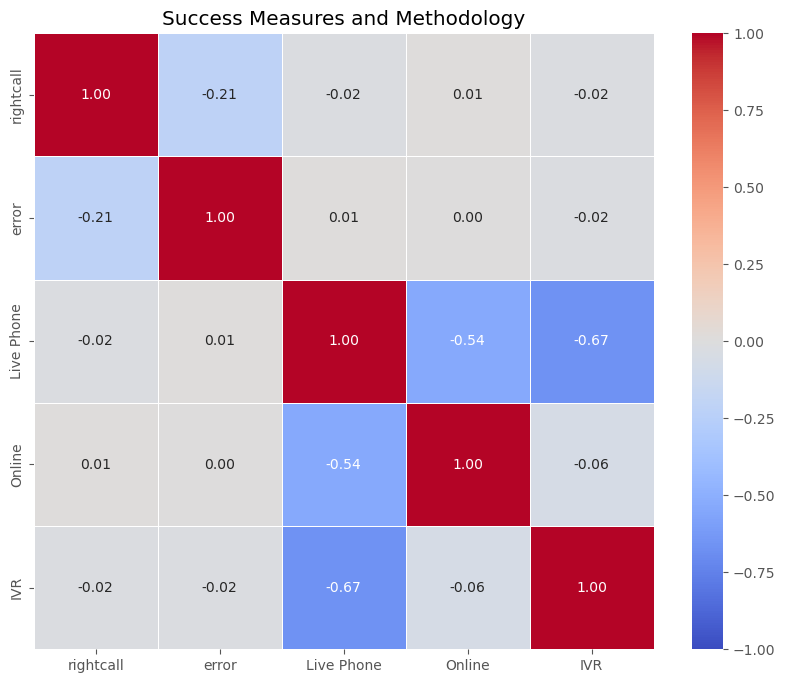

In [83]:
heatmap_data = df[['rightcall', 'error', 'Live Phone', 'Online', 'IVR']]
correlation_matrix = heatmap_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, 
            cmap='coolwarm', fmt='.2f', 
            linewidths=.5, vmax = 1, vmin = -1)
plt.title('Success Measures and Methodology');

Looking instead at our most common methodologies we see some correlations between them which we expect because we know from our feature extraction stage that polls could use multiple methodologies. Unfortunately, we see no correlation between either and our success metrics so this is seeming like a dead end and a moderate worry for our future modelling.

Let's pivot and take a more circumspect approach to our exploration.

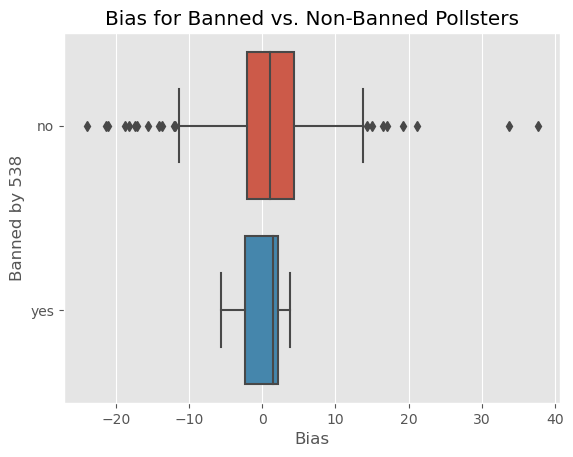

In [76]:
sns.boxplot(pollster_ratings, x = 'Bias', y = 'Banned by 538')

plt.title('Bias for Banned vs. Non-Banned Pollsters');

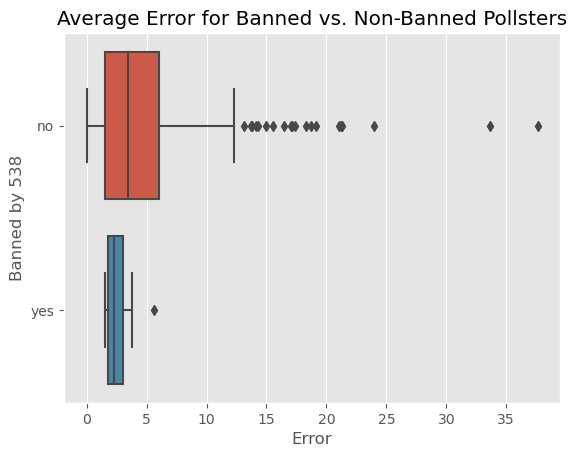

In [79]:
sns.boxplot(x = np.abs(pollster_ratings['Bias']), y = pollster_ratings['Banned by 538'])

plt.xlabel('Error')
plt.title('Average Error for Banned vs. Non-Banned Pollsters');

In [107]:
pollster_ratings['Banned by 538'].value_counts(), df['Banned by 538'].value_counts() # barely any are banned

(Banned by 538
 no     506
 yes     11
 Name: count, dtype: int64,
 Banned by 538
 no     10155
 yes      600
 Name: count, dtype: int64)

In [106]:
df.groupby('Banned by 538')['rightcall'].mean()

Banned by 538
no     0.801329
yes    0.815000
Name: rightcall, dtype: float64

538 has banned a number of pollsters from being included in their models (11 to precise). Interestingly, by measures of error, bias, and accuracy, there is no observable difference between the polls that are banned and polls that are not banned. This suggest that 538 is using other qualitative reasons to exclude these pollsters and not basing it on the quanitfiable data. This, along with our lack of correlation, is starting to paint a picture that our modelling task may not lead us to much.

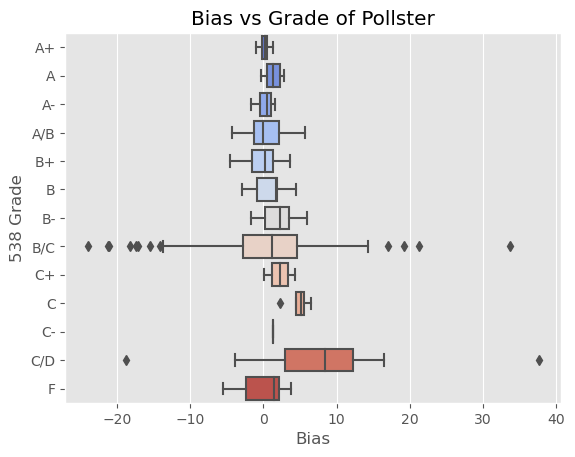

In [20]:
sns.boxplot(pollster_ratings, 
            x = 'Bias', 
            y = '538 Grade', 
            palette = 'coolwarm', 
            order = ['A+', 'A', 'A-', 'A/B', 'B+', 'B', 'B-', 'B/C', 'C+', 'C', 'C-', 'C/D', 'F'],
        )

plt.title('Bias vs Grade of Pollster');

In [21]:
pollster_ratings['538 Grade'].value_counts()[sorted(pollster_ratings['538 Grade'].unique())] 
# Vast majority of pollsters are graded B/C

538 Grade
A        8
A+       4
A-       9
A/B     47
B       10
B+      11
B-       9
B/C    382
C        4
C+       2
C-       1
C/D     19
F       11
Name: count, dtype: int64

When looking at Pollster Bias across the different grades we see that generally the higher ranked pollsters have much less variance in their bias values but overall, most of our grades do average to around 0 bias. The counts reveal that the vast majority of our pollsters are rated 'B/C' which is an average grade. We also see that there are only 11 with an 'F' grade which should be the 11 that are banned.

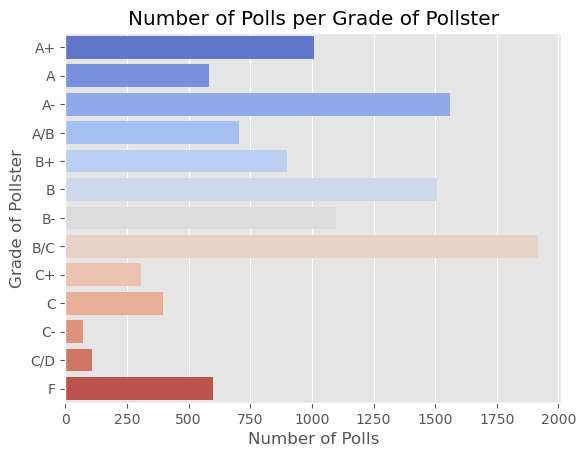

In [32]:
grade_count = df['538 Grade'].value_counts()[
    ['A+', 'A', 'A-', 'A/B', 'B+', 'B', 'B-', 'B/C', 'C+', 'C', 'C-', 'C/D', 'F']
    ]
sns.barplot(x = grade_count.values, y = grade_count.index, palette = 'coolwarm')

# Display the plot
plt.title('Number of Polls per Grade of Pollster')
plt.xlabel('Number of Polls')
plt.ylabel('Grade of Pollster');
# However the total number of polls analyzed is more even

In [110]:
df['538 Grade'].dropna().value_counts()[sorted(df['538 Grade'].dropna().unique())] 

538 Grade
A       582
A+     1007
A-     1560
A/B     703
B      1507
B+      898
B-     1097
B/C    1916
C       397
C+      307
C-       72
C/D     109
F       600
Name: count, dtype: int64

This paints a very different picture from our pollster count by grades table above. While there are fewer pollsters with high grades, those high-quality pollsters are overrepresented in terms of volume of polls. This is heartening to see, good pollsters making up a disproportionate amount of our polls means that generally the aggregates that 538 calculates for their model will be more accurate. 

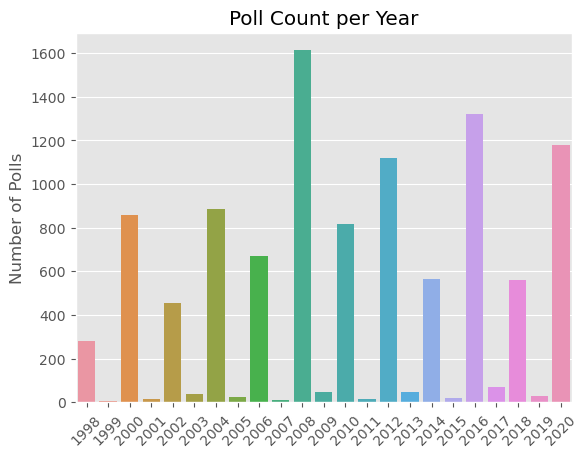

In [22]:
polls_vs_year = df.groupby('year')['Bias'].count()
sns.barplot(
    x = polls_vs_year.index,
    y = polls_vs_year.values
)
plt.xticks(rotation = 45)
plt.xlabel('')
plt.ylabel('Number of Polls')
plt.title('Poll Count per Year');

We see spikes with every election cycle as expected though interestingly we don't see polls increasing over time. While we see an initial growth from 1998 to 2008, it seems that after that period the number of polls tamps down a bit, though its still generally above the pre-2008 average for presidential elections at least. For non-presidential election years we see that the number of polls are about the same level as 2002 and 2006, though there is a relative spike in 2010. As a whole, it seems there was an explosion of polling from 1998-2008 which then regressed a bit as pollsters realized that quantity doesn't necessarily beat quality.

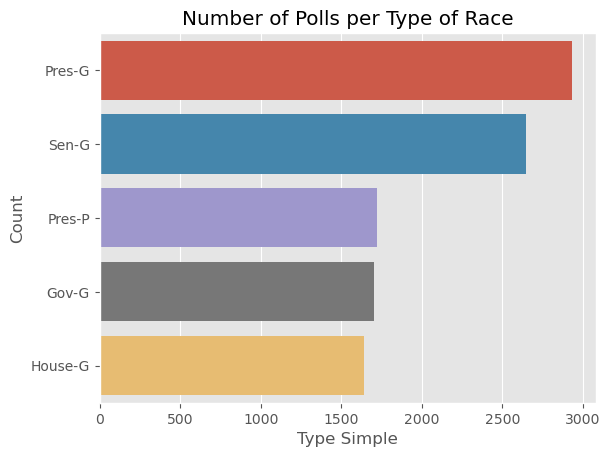

In [30]:
# Bar Chart of Number of Polls per Type of Race 
poll_count = df.groupby('type_simple')['Bias'].count().sort_values(ascending = False)

sns.barplot(x = poll_count.values, y = poll_count.index)
plt.title('Number of Polls per Type of Race')
plt.xlabel('Race Type')
plt.ylabel('Count');

#showing us that General Presidental pollings has the most number of polls followed by General Senate polling. Primary, Governor, and House polling has less polls, probably because less demand/readership of these races compared to Presidental and Senate races.

In [24]:
df.groupby('type_simple')['Bias'].count()

type_simple
Gov-G      1706
House-G    1641
Pres-G     2933
Pres-P     1721
Sen-G      2647
Name: Bias, dtype: int64

We see most of our polling is done on Presidential general election (as expected, that's the one people care most about) but we also see quite a few Senate general polls. We would expect that House general would be more prolific simply due to there being over 4 times as many House seats compared to Senate seats. Its hard to make heads or tails of this but one potential explanation is that generally House races are less competitive (or at least *perceived* as less competitive) so there is less polling being done for them.

Extending this concept of how polling changed over time, let's see how poll accuracy changed over the years.

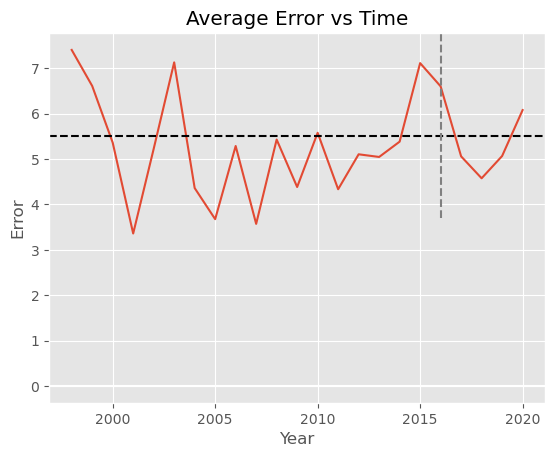

In [71]:
sns.lineplot(df.groupby('year')['error'].mean())

plt.axhline(y = np.mean(df['error']), color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'white')
plt.axvline(x = 2016, ymin = 0.5, color = 'grey', linestyle = '--')

plt.ylabel('Error')
plt.xlabel('Year')
plt.title('Average Error vs Time');

We see a fair amount of volatility in the average error for each year, we seem to be more accurate during non-presidential cycles. This makes sense, only the more politically tuned voters vote during off-years and they will generally be easier to capture in a poll about elections. Aside from that, there is no general trend across the years which is quite interesting. One note is that we had less volatility in the mid to late 2000s compared to 2014 and on. Thinking back to the number of polls across years its hard to explain why exactly this happened. Additionally, we have 2016 marked here because 2016 was a year that the polls famously failed. However we see the error was only one point higher than the average since 1998 so all things considered not particularly bad. We also see that error was a bit higher even in 2014 than it was in 2016.

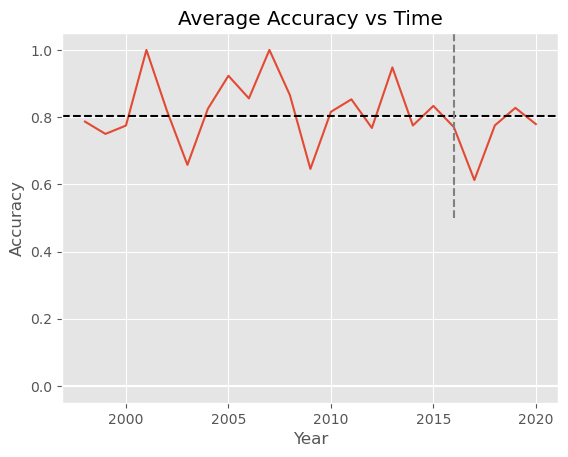

In [119]:
sns.lineplot(df.groupby('year')['rightcall'].mean())

plt.axhline(y = np.mean(df['rightcall']), color = 'black', linestyle = '--')
plt.axhline(y = 0, color = 'white')
plt.axvline(x = 2016, ymin = 0.5, color = 'grey', linestyle = '--')

plt.ylabel('Accuracy')
plt.xlabel('Year')
plt.title('Average Accuracy vs Time');

When we look at accuracy (average of rightcall) for each year we see a similar stationary trend as we saw with error but there are a few interesting differences. Firstly, while we saw less error in the 2005-2010 period we see no particular trend in accuracy which explains the generally low correlation we saw earlier. Most interestingly perhaps is that in 2016, polls were only slightly worse than average and actually in 2018 we saw our worst accuracy by quite a fair margin (especially within the post 2010 era). Our error plot showed lower error for 2018 which is quite interesting. We can suppose that most likely in 2018 the races were predicted to be close but the front-runner was predicted incorrectly a bit more frequently than other years.

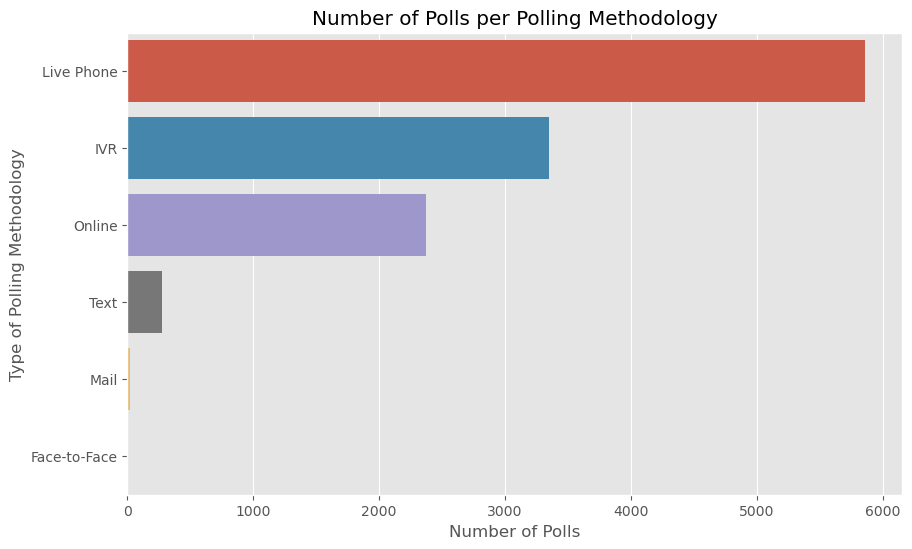

In [117]:
#re-creating a bar chart that represents the most used methodologies of polling with cleaned values
methods = df[['Text', 'Live Phone', 'Mail', 'Face-to-Face', 'IVR', 'Online']]

# Calculate the counts for each method
method_counts = methods.sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=method_counts.values, y=method_counts.index)
# Display the plot on Number of Polls per Polling Methodology
plt.title('Number of Polls per Polling Methodology')
plt.xlabel('Number of Polls')
plt.ylabel('Type of Polling Methodology');

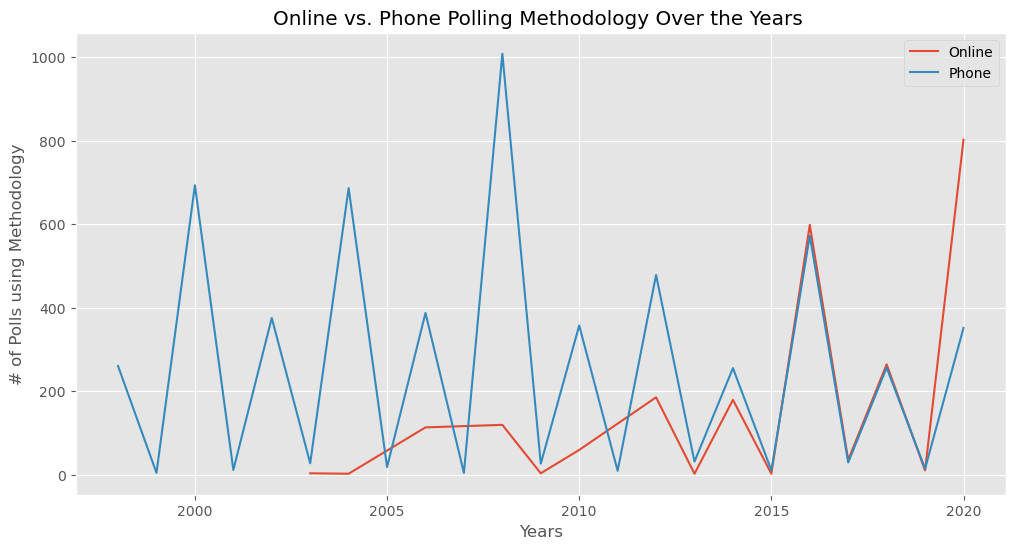

In [55]:
phone = df[df['Live Phone'] == 1].groupby('year')[['Live Phone']].count()
online = df[df['Online'] == 1].groupby('year')[['Online']].count()

fig, ax = plt.subplots(figsize = (12, 6))
ax1 = sns.lineplot(online["Online"], ax=ax, label="Online")
ax2 = sns.lineplot(phone["Live Phone"], ax=ax, label="Phone")
ax.legend();
plt.title('Online vs. Phone Polling Methodology Over the Years ')
plt.xlabel('Years')
plt.ylabel('# of Polls using Methodology');

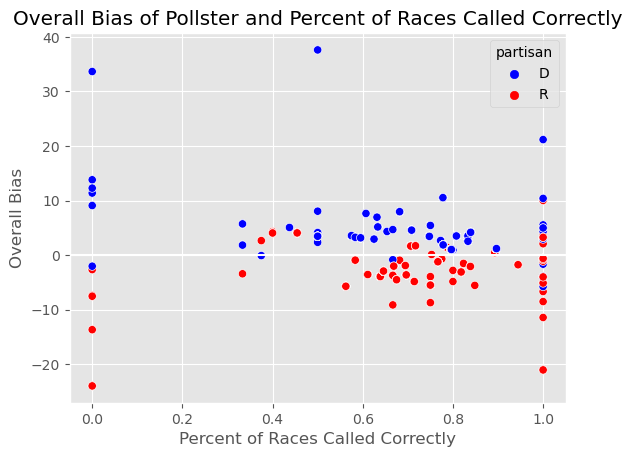

In [100]:
#Overall Bias of Pollster and Percent of Races Called Correctly
#This chart might be misleading since we are using the merged data set with the rating data 
#going to use the chart below that only looks at rating data instead but conveys the same message that partisan aligned polls will lean towards their party
partisan_palette = {'D': 'blue', 'R': 'red'}
default_color = 'grey'

sns.scatterplot(
    data = df[(df['partisan'] == 'D') | (df['partisan'] == 'R')],
    x = 'Races Called Correctly',
    y = 'Bias',
    palette=partisan_palette,
    hue='partisan',
    hue_order=['D', 'R'],
    edgecolor='w',
    legend='full'
)


plt.title('Overall Bias of Pollster and Percent of Races Called Correctly')
plt.xlabel('Percent of Races Called Correctly')
plt.ylabel('Overall Bias');

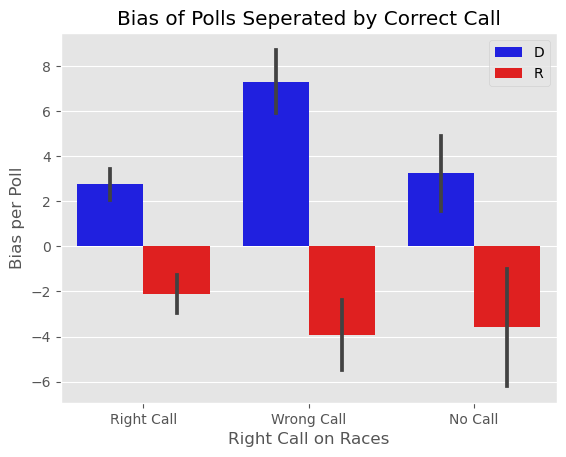

In [46]:
partisan_palette = {'D': 'blue', 'R': 'red','NPL': (0.6, 0.6, 0.6, 0.01), 'IND': (0.6, 0.6, 0.6, 0.01)}

# Create a bar plot
sns.barplot(
    x=df['rightcall'].astype(str),
    y=df['bias'],
    palette=partisan_palette,
    hue=df['partisan'],
    hue_order=['D', 'R'],
    edgecolor='none'
)

# Set the title and labels
plt.xticks(ticks = [0,1,2], labels = ['Right Call', 'Wrong Call', 'No Call'])
plt.title('Bias of Polls Seperated by Correct Call')
plt.xlabel('Right Call on Races')
plt.ylabel('Bias per Poll')

# Show the legend
plt.legend(loc='upper right');

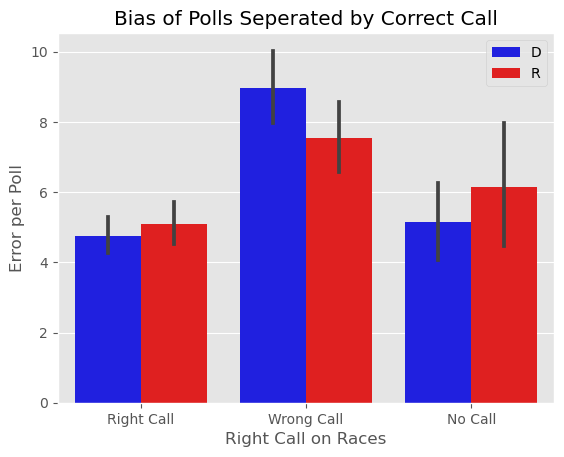

In [53]:
sns.barplot(
    x=df['rightcall'].astype(str),
    y=df['error'],
    palette=partisan_palette,
    hue=df['partisan'],
    hue_order=['D', 'R'],
    edgecolor='none'
)

# Set the title and labels
plt.xticks(ticks = [0,1,2], labels = ['Right Call', 'Wrong Call', 'No Call'])
plt.title('Bias of Polls Seperated by Correct Call')
plt.xlabel('Right Call on Races')
plt.ylabel('Error per Poll')

# Show the legend
plt.legend(loc='upper right');

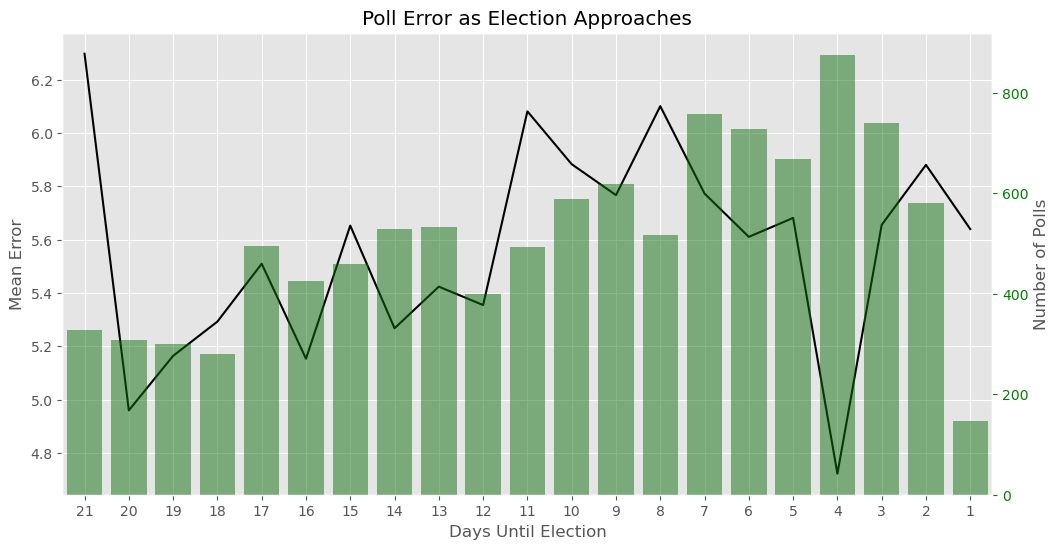

In [49]:
error_vs_days = df.groupby('days_bt_polldate_election')['error'].mean()
polls_vs_days = df.groupby('days_bt_polldate_election')['error'].count()

_, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x =  error_vs_days.index - 1, y = error_vs_days.values, ax = ax, color = 'black')
# ax.set_xticks(ticks = range(-21, 0), labels = range(21, 0, -1))
ax2 = ax.twinx()
sns.barplot(x = -1 * polls_vs_days.index, y = polls_vs_days.values, color = 'green', ax  = ax2, alpha = 0.5)
ax2.grid(False);
ax2.set_xticks(ticks = ax.get_xticks(), labels = range(21, 0, -1)); # ticks = range(-21, 0), 

plt.title('Poll Error as Election Approaches')
ax.set_xlabel('Days Until Election')
ax.set_ylabel('Mean Error')
ax2.set_ylabel('Number of Polls')

ax2.tick_params(colors = 'green', which = 'major');

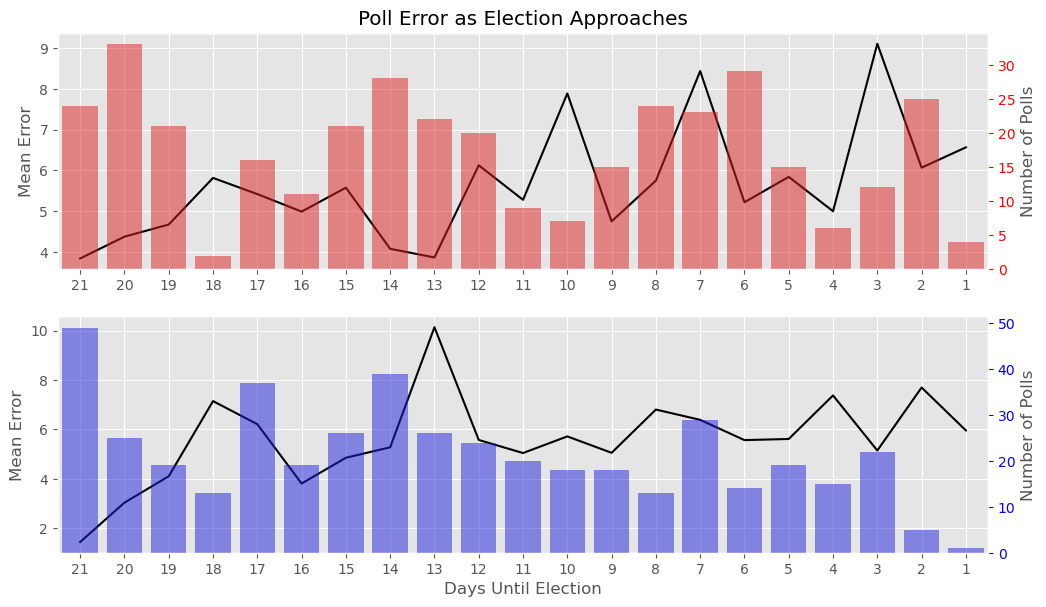

In [51]:
reps_e_by_days = df[df['partisan'] == 'R'].groupby(
    'days_bt_polldate_election'
    )['error'].mean()
reps_p_by_days = df[df['partisan'] == 'R'].groupby(
    'days_bt_polldate_election'
    )['error'].count()

dems_e_by_days = df[df['partisan'] == 'D'].groupby(
    'days_bt_polldate_election'
    )['error'].mean()
dems_p_by_days = df[df['partisan'] == 'D'].groupby(
    'days_bt_polldate_election'
    )['error'].count()


_, ax = plt.subplots(nrows = 2, figsize = (12,9*.75))

sns.lineplot(x =  reps_e_by_days.index - 1, y = reps_e_by_days.values, ax = ax[0], color = 'black')
# ax.set_xticks(ticks = range(-21, 0), labels = range(21, 0, -1))
ax02 = ax[0].twinx()
sns.barplot(x = -1 * reps_p_by_days.index, y = reps_p_by_days.values, color = 'red', ax  = ax02, alpha = 0.5)
ax02.grid(False);
ax02.set_xticks(ticks = ax[0].get_xticks(), labels = range(21, 0, -1)); # ticks = range(-21, 0), 

plt.title('Poll Error as Election Approaches')
ax[0].set_xlabel('')
ax[0].set_ylabel('Mean Error')
ax02.set_ylabel('Number of Polls')

ax02.tick_params(colors = 'red', which = 'major')

sns.lineplot(x =  dems_e_by_days.index - 1, y = dems_e_by_days.values, ax = ax[1], color = 'black')
# ax.set_xticks(ticks = range(-21, 0), labels = range(21, 0, -1))
ax12 = ax[1].twinx()
sns.barplot(x = -1 * dems_p_by_days.index, y = dems_p_by_days.values, color = 'blue', ax  = ax12, alpha = 0.5)
ax12.grid(False);
ax12.set_xticks(ticks = ax[1].get_xticks(), labels = range(21, 0, -1)); # ticks = range(-21, 0), 

#plt.title('Poll Error as Election Approaches')
ax[1].set_xlabel('Days Until Election')
ax[1].set_ylabel('Mean Error')
ax12.set_ylabel('Number of Polls')

ax12.tick_params(colors = 'blue', which = 'major');

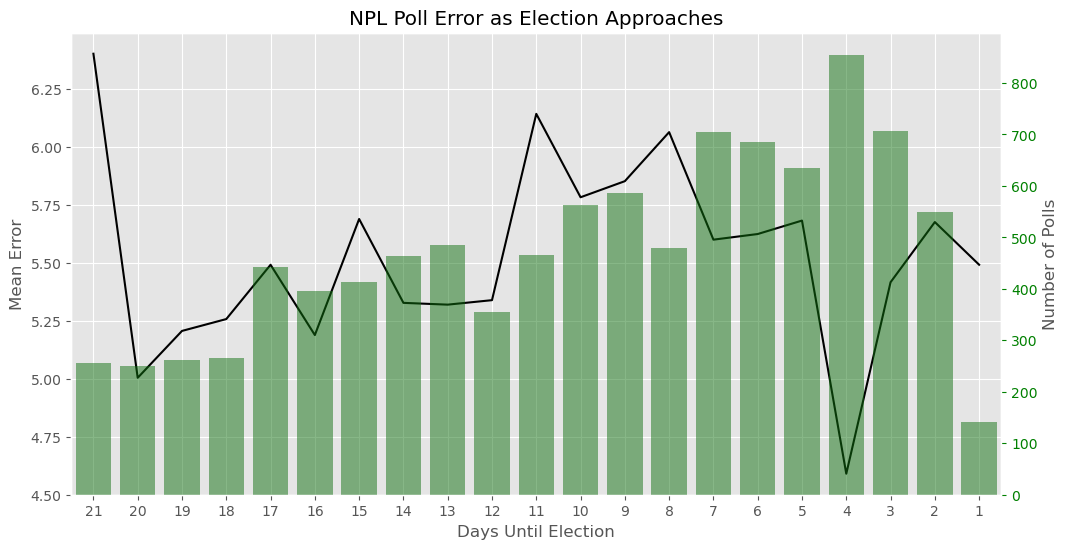

In [101]:
error_vs_days = df[df['partisan'] == 'NPL'].groupby('days_bt_polldate_election')['error'].mean()
polls_vs_days = df[df['partisan'] == 'NPL'].groupby('days_bt_polldate_election')['error'].count()

_, ax = plt.subplots(figsize = (12,6))
sns.lineplot(x =  error_vs_days.index - 1, y = error_vs_days.values, ax = ax, color = 'black')
# ax.set_xticks(ticks = range(-21, 0), labels = range(21, 0, -1))
ax2 = ax.twinx()
sns.barplot(x = -1 * polls_vs_days.index, y = polls_vs_days.values, color = 'green', ax  = ax2, alpha = 0.5)
ax2.grid(False);
ax2.set_xticks(ticks = ax.get_xticks(), labels = range(21, 0, -1)); # ticks = range(-21, 0), 

plt.title('NPL Poll Error as Election Approaches')
ax.set_xlabel('Days Until Election')
ax.set_ylabel('Mean Error')
ax2.set_ylabel('Number of Polls')

ax2.tick_params(colors = 'green', which = 'major');